$$
\begin{aligned}
\mu_{\mathrm{A}}\left(\mathrm{c}_{\mathrm{A}}\right)= & \mu_{\mathrm{A}}^0+\mathrm{k}_{\mathrm{B}} \mathrm{T} \ln \left(\frac{\mathrm{c}_{\mathrm{A}}}{\mathrm{c}_{\mathrm{A}}^0}\right) \\
& +\mathrm{k}_{\mathrm{B}} \mathrm{T} \int_{\ln \mathrm{c}_{\mathrm{A}}^0}^{\ln \mathrm{c}_{\mathrm{A}}} \mathrm{d} \ln \left(\mathrm{c}_{\mathrm{A}}\right)\left[\frac{1}{\mathrm{~S}_{\mathrm{AA}}^0-\mathrm{S}_{\mathrm{AB}}^0 \sqrt{\mathrm{c}_{\mathrm{A}} / \mathrm{c}_{\mathrm{B}}}}-1\right]
\end{aligned}
$$

the non-ideal part refers to excess chemcial potential:
$$
\mathrm{k}_{\mathrm{B}} \mathrm{T} \int_{\ln \mathrm{c}_{\mathrm{A}}^0}^{\ln \mathrm{c}_{\mathrm{A}}} \mathrm{d} \ln \left(\mathrm{c}_{\mathrm{A}}\right)\left[\frac{1}{\mathrm{~S}_{\mathrm{AA}}^0-\mathrm{S}_{\mathrm{AB}}^0 \sqrt{\mathrm{c}_{\mathrm{A}} / \mathrm{c}_{\mathrm{B}}}}-1\right]
$$

In [7]:
import numpy as np
import scipy
from scipy import signal
import matplotlib.pyplot as plt
from math import pi, isinf
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.misc import derivative
from scipy.optimize import curve_fit
import scipy.constants
import math
import numpy as np

def excess_mu(ca,saa,sab,nratio,c0,kbt):
    # ca, nratio are 1-D array with N-dim
    # saa,sab are (2,N) array, [S, S_error]
    integrand = 1./(saa[:,0]-sab[:,0]*(nratio)**0.5) -1.
    integrand_error = 0.5*abs(1./((saa[:,0]-saa[:,1])-(sab[:,0]+sab[:,1])*(nratio)**0.5)-1./((saa[:,0]+saa[:,1])-(sab[:,0]-sab[:,1])*(nratio)**0.5))
    logca = np.log(ca)
    index = np.argwhere(integrand == float("inf"))
    integrand[index] = float('nan')
    
    mask = ~np.isnan(integrand)

    int_func = interp1d(logca[mask], integrand[mask], kind='linear',fill_value='extrapolate')
    int_error_func = interp1d(logca[mask], integrand_error[mask], kind='linear',fill_value='extrapolate')
    
    # integrate
    ca_mu = []
    n_sample = 0
    for i,a in enumerate(logca):
        if ca[i] > 0:
            n_sample+=1
            mu_now = kbt*quad(int_func, np.log(c0), a)[0]
            if n_sample >= 2:
                mu_error_now = kbt*quad(int_error_func, np.log(c0), a)[0]/(n_sample-1)**0.5
            else:
                mu_error_now = kbt*quad(int_error_func, np.log(c0), a)[0]
            ca_mu.append([ca[i],mu_now, mu_error_now])
        
    return np.asarray(ca_mu)
    

# Read in data

In [8]:
import jax.numpy as jnp
gp_data = dict(jnp.load("./gp_predict_nacl.npz"))

mu_a = gp_data["mu_a"]
mu_a_err = gp_data["mu_a_err"]

/tmp/ipykernel_339/1949649470.py:34: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  mu_now = kbt*quad(int_func, np.log(c0), a)[0]
/tmp/ipykernel_339/1949649470.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special

Text(0.5, 0, '$m_\\mathrm{NaCl}$ [mol/kg]')

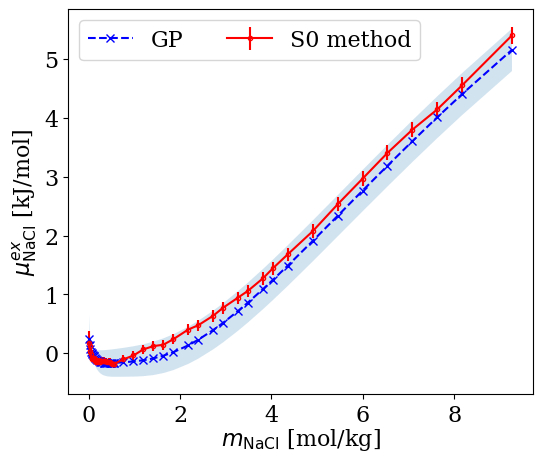

In [10]:
kbT= 2.4943387854 #（unit for mu, KJ/mol)
# read in data
data = np.loadtxt("./NaCl_in_water_data.txt", skiprows = 2)
ca_now  = data[::,0]
ca_ratio_now = data[::,1]
m_now = data[::,2]
saa_now = data[:,3:5]
sab_now = data[:,5:7]
mu_nacl = excess_mu(ca_now, saa_now, sab_now, ca_ratio_now, 0.1, kbT)
font = {"family": "serif", "size": 16}
plt.rc("font", **font)
plt.rc("text", usetex=False)
fig, ax = plt.subplots(1,1,figsize=(6,5),sharex=True)
ax.errorbar(m_now,mu_nacl[:,1],yerr=np.abs(mu_nacl[:,2]),
            marker=".",markerfacecolor="None",
            c="r", label="S0 method")

plt.plot(jnp.sort(m_now), mu_a, c="b", ls="--", marker="x", label="GP")
plt.fill_between(jnp.sort(m_now), mu_a-mu_a_err, mu_a+mu_a_err, alpha=0.2)

ax.legend(ncol=2,fontsize=16)
ax.set_ylabel("$\mu^{ex}_\mathrm{NaCl}$ [kJ/mol]")
ax.set_xlabel("$m_\mathrm{NaCl}$ [mol/kg]",labelpad=0)

# ax.set_xlim(0,1)
# ax.set_ylim(-0.5,0.5)